<a href="https://colab.research.google.com/github/tableClothed/ML-Projects/blob/master/Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[THE TUTORIAL](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system)

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
# drive.mount('/content/gdrive')

link = "/content/gdrive/My Drive/Colab Notebooks"

credits = pd.read_csv(link + "/tmdb_5000_credits.csv")
movies = pd.read_csv(link + "/tmdb_5000_movies.csv")

In [0]:
credits.columns = ['id', 'title', 'cast', 'crew']
movies = movies.merge(credits, on='id')

movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


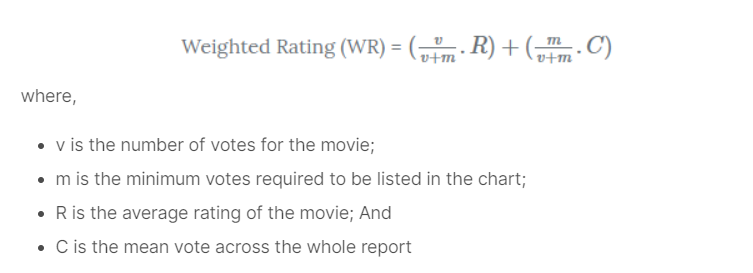

In [0]:
C = movies['vote_average'].mean()
C

6.092171559442011

In [0]:
# minimum votes required to be listed in the chart
# let's say at least 90%

m = movies['vote_count'].quantile(0.9)
m

1838.4000000000015

In [0]:
# filtering movies that qualify for the chart

q_movies = movies.copy().loc[movies['vote_count'] >= m]
q_movies.shape

(481, 23)

In [0]:
# there are 481 movies, which qualify to be in this list

# now calculating metric for each qualified movie

def weighted_ratings(x, m=m, C=C):
  v = x['vote_count']
  R = x['vote_average']

  # calc as above based on the IMDB formula:
  return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
# define a new feature 'score' and calculate its value with 'weighted rating()

q_movies['score'] = q_movies.apply(weighted_ratings, axis=1)

In [0]:
# sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

# Print the top 15 movies
q_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

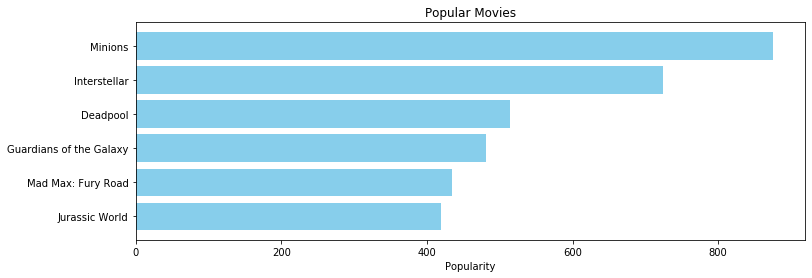

In [0]:
pop = movies.sort_values('popularity', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(
    pop['original_title'].head(6),
    pop['popularity'].head(6),
    align='center',
    color='skyblue')

# gca - get current class axes
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title('Popular Movies')


# that is a general chart of recommended movies to all users
# it is not sensitive to th interests and tastes of a particular user

### CONTENT BASED FILTRING

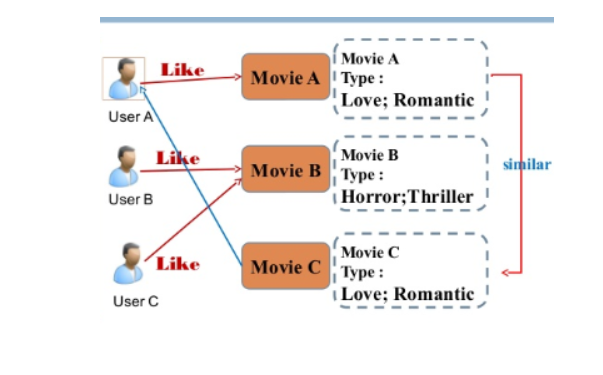

In [0]:
movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

Obliczyć wektory Term Frequency-Inverse Frequency Document (TF-IDF) dla każdego przeglądu.

Term Frequency jest to względna częstotliwość słowa w dokumencie i jest podawana jako (instancje terminowe / instancje ogółem). Odwrotna częstotliwość dokumentów to względna liczba dokumentów zawierających termin podawana jako log (liczba dokumentów / dokumentów z terminem) Ogólna waga każdego słowa dla dokumentów, w których występują, jest równa TF * IDF.

Otrzymasz macierz, w której każda kolumna reprezentuje słowo w słowniku ogólnym (wszystkie słowa, które pojawiają się w co najmniej jednym dokumencie), a każda kolumna reprezentuje film, jak poprzednio. Ma to na celu zmniejszenie znaczenia często występujących słów w przeglądach wykresów, a zatem ich znaczenie w obliczaniu końcowego wyniku podobieństwa.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# defining a TF-IDF Vectorizer Object. Removing all english words such as 'the', 'a'
tfdif = TfidfVectorizer(stop_words='english')

# replace NaN with an empty string
movies['overview'] = movies['overview'].fillna('')

# construct the required TF-IDF mattix by fitting and transforming the data
tfdif_matrix = tfdif.fit_transform(movies['overview'])

# the shape of matrix
tfdif_matrix.shape

(4803, 20978)

In [0]:
# over 20,000 different words were used to describe the 4800 movies in dataset

# computing a similiarity score

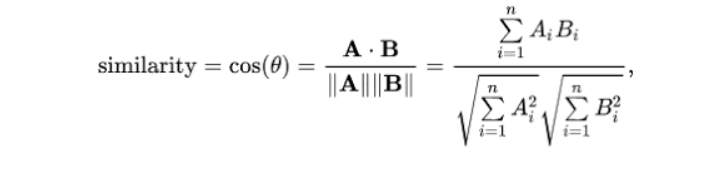

In [0]:
# Ponieważ użyliśmy wektoryzatora TF-IDF, obliczenie iloczynu
# kropkowego (dot product) da nam bezpośredni wynik podobieństwa cosinus.
# Dlatego użyjemy linear_kernel() sklearn'a zamiast cosine_similarities(),
# ponieważ jest on szybszy.

from sklearn.metrics.pairwise import linear_kernel

# cosine similiarity matrix

cosine_sim = linear_kernel(tfdif_matrix, tfdif_matrix)

In [0]:
# coonstructiong a reverse map of indices(wskaźniki) and movie titles

indices = pd.Series(movies.index, index=movies['original_title']).drop_duplicates()

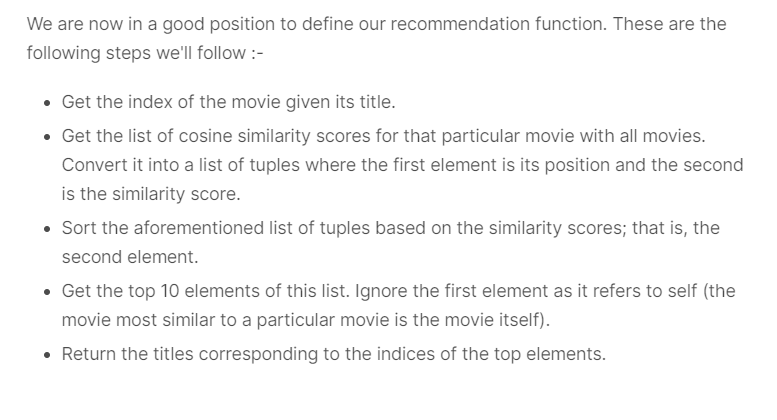

In [0]:
# fuction that takes in movie title as input and outputs most similiar movies

def get_recommendations(title, cosine_sim=cosine_sim):
  # get the index of the movie that matches the title
  idx = indices[title]

  # get the pairwise similiarity (podobieństwo parami) scores of all movies with that movie
  sim_scores = list(enumerate(cosine_sim[idx]))

  # sort the movies based on the similiarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get the scores of the top 10 most similiar movies
  sim_scores = sim_scores[1:11]

  # get the movie indices
  movie_indices = [i[0] for i in sim_scores]

  # return the top 10 most similiar movies
  return movies['original_title'].iloc[movie_indices]

In [0]:
get_recommendations('American Beauty')

3983                 Hustle & Flow
2875                    Two Lovers
3596             Y tu mamá también
1964          The Whole Nine Yards
2043                     Homefront
3313                  An Education
4614                   3 Backyards
3276    It's Kind of a Funny Story
1552          The First Wives Club
4575             Napoleon Dynamite
Name: original_title, dtype: object

In [0]:
get_recommendations('The Godfather')

2731     The Godfather: Part II
1873                 Blood Ties
867     The Godfather: Part III
3727                Snabba Cash
3623                       Made
3125                     Eulogy
3896                   Sinister
4506            The Maid's Room
3783                        Joe
2244      The Cold Light of Day
Name: original_title, dtype: object

### CREDIT, GENRES AND KEYWORDS BASED RECOMMENDER

Rekomendator w oparciu o następujące metadane: 3 najlepszych aktorów, reżyser, pokrewne gatunki i słowa kluczowe fabuły.

In [0]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
  movies[feature] = movies[feature].apply(literal_eval)

In [0]:
# get the director's name from the crew feature
# if director's isn't listed, return NaN

def get_director(x):
  for i in x:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [0]:
# returns the list top 3 elements or entire list; whichever is more

def get_list(x):
  if isinstance(x, list):
    names = [i['name'] for i in x]
    # check if more than 3 elements exist. If yes, return only first three.
    # if no, return entire list
    if len(names) > 3:
      names = names[:3]
    return names

  # return empty list in case of missing/mlformed data
  return []

In [0]:
# define new director, cast, genres and keywords features that are in a suitable form

movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
  movies[feature] = movies[feature].apply(get_list)

In [0]:
# print the new features of the first 3 films
movies[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [0]:
# convert the  names and keywords into lowercase and strip all the spaces between them

def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(" ", "")) for i in x]
  else:
    # check if director exists. If not, return empty string
    if isinstance(x, str):
      return str.lower(x.replace(" ", ""))
    else:
      return ''

In [0]:
# apply clean_data func to features

features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
  movies[feature] = movies[feature].apply(clean_data)

In [0]:
# metadata soup - a string that cntains all the metadata we want to feed
# to our vectorizer (namely actors, director and keywords)

def create_soup(x):
  return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

movies['soup'] = movies.apply(create_soup, axis=1)

In [0]:
# actions similiar like during using the TF-IDF but instead using
# CountVectorizer()

from sklearn.feature_extraction.text import  CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


In [0]:
# reset index of main DataFrame and construct reverse mapping as before

movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['original_title'])

In [0]:
get_recommendations('Titanic', cosine_sim2)

1081             Revolutionary Road
4247          Me You and Five Bucks
49                 The Great Gatsby
872              All the King's Men
1311                     Angel Eyes
1492                     The Reader
2449          Sense and Sensibility
2661                 Romeo + Juliet
2701                Little Children
2946    What's Eating Gilbert Grape
Name: original_title, dtype: object

In [0]:
get_recommendations('American Pie', cosine_sim2)

1540             American Pie 2
1934            Say It Isn't So
4247      Me You and Five Bucks
4626           Anderson's Cross
397            It's Complicated
817            American Wedding
2355    I Love You, Beth Cooper
1756                About a Boy
2036           Saving Silverman
2190                      Loser
Name: original_title, dtype: object

### COLLABORATIVE FILTERING

Nasz silnik oparty na treści ma poważne ograniczenia. Może sugerować tylko filmy, które są zbliżone do określonego filmu. Oznacza to, że nie jest w stanie uchwycić gustów i dostarczyć rekomendacji dla różnych gatunków.

Ponadto silnik, który zbudowaliśmy, nie jest tak naprawdę osobisty, ponieważ nie oddaje osobistych upodobań i uprzedzeń użytkownika. Każdy, kto zapyta nasz silnik o rekomendacje oparte na filmie, otrzyma takie same rekomendacje dla tego filmu, niezależnie od tego, kim jest.

Dlatego w tej sekcji użyjemy techniki o nazwie Filtrowanie grupowe, aby sformułować zalecenia dla obserwatorów filmów. Zasadniczo składa się z dwóch rodzajów:

> **FILTROWANIE NA PODSTAWIE UŻYTKOWNIKA**

 Systemy te polecają produkty użytkownikowi podbnemu innym użytkownikom. Do pomiaru podobieństwa między dwoma użytkownikami możemy użyć korelacji Pearsona lub podobieństwa cosinus.

> **FILTROWANIE OPARTE NA WSPÓŁPRACY OPARTE NA ELEMENTACH**

Zamiast mierzyć podobieństwo między użytkownikami, oparty na elementach system CF poleca elementy na podstawie ich podobieństwa z elementami ocenianymi przez docelowego użytkownika. Podobnie podobieństwo można obliczyć za pomocą korelacji Pearsona lub podobieństwa kosinusowego. Główną różnicą jest to, że dzięki filtrowaniu grupowemu opartemu na elementach wypełniamy puste miejsce w pionie, w przeciwieństwie do poziomego sposobu, w jaki CF oparty na użytkownikach.

Z powodzeniem pozwala uniknąć problemu wynikającego z dynamicznych preferencji użytkownika, ponieważ system CF oparty na elementach jest bardziej statyczny. Jednak dla tej metody pozostaje kilka problemów. Po pierwsze, głównym problemem jest **skalowalność**. Obliczenia rosną wraz z klientem i produktem. W najgorszym przypadku złożoność to O(mn) przy m użytkownikach i n elementach. Ponadto **rzadkość** stanowi kolejny problem. W skrajnych przypadkach możemy mieć miliony użytkowników, a podobieństwo między dwoma dość różnymi filmami może być bardzo wysokie po prostu dlatego, że mają podobną pozycję jedyny użytkownik, który umieścił je w rankingu.
 


### SINGLE VALUE DECOMPOSITION- ROZKŁAD POJEDYNCZEJ WARTOŚCI

Jednym ze sposobów radzenia sobie z problemem skalowalności i rzadkości utworzonym przez CF jest wykorzystanie **modelu ukrytego czynnika** w celu uchwycenia podobieństwa między użytkownikami i elementami. Zasadniczo chcemy przekształcić problem rekomendacji w problem optymalizacji. Możemy to postrzegać jako dobre w przewidywaniu oceny produktów dla danego użytkownika. Jednym z powszechnych mierników jest Root Mean Square Error (RMSE). **Im niższa wartość RMSE, tym lepsza wydajność.**
 

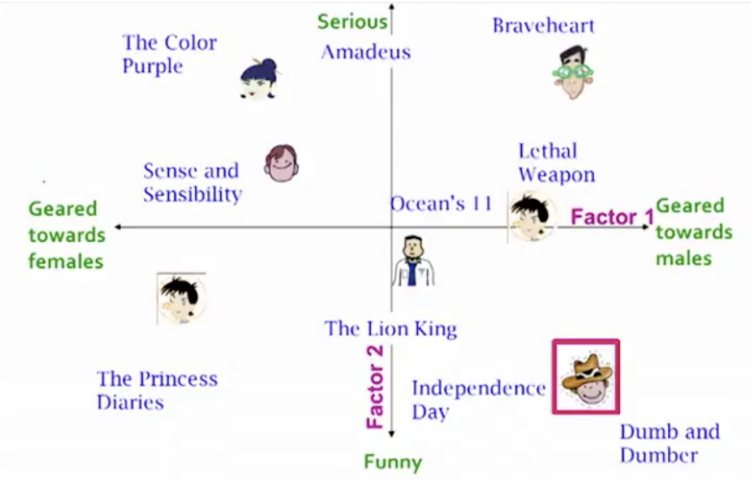

In [0]:
#!git clone https://github.com/NicolasHug/surprise.git
# ! pip install surprise
# ! pip install scikit-surprise


from surprise import Reader, Dataset, SVD, dataset
from surprise.model_selection import cross_validate

reader = Reader()
ratings = pd.read_csv(link + "/ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
data2 = Dataset.load_from_df(
    ratings[['userId', 'movieId', 'rating']],
    reader)

In [0]:
svd = SVD()
cross_validate(svd, data2, measures=['RMSE', 'MAE'])

{'fit_time': (5.036221504211426,
  5.095395565032959,
  5.128539562225342,
  5.161294221878052,
  5.191207647323608),
 'test_mae': array([0.69909716, 0.68632283, 0.68686732, 0.69097133, 0.68911955]),
 'test_rmse': array([0.90749794, 0.89007238, 0.8905181 , 0.89787982, 0.89967532]),
 'test_time': (0.14414691925048828,
  0.1379537582397461,
  0.15212607383728027,
  0.16762828826904297,
  0.1637735366821289)}

In [0]:
trainset = data2.build_full_trainset()
svd.fit(trainset)

In [0]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [0]:
svd.predict(uid=1, iid=302, r_ui=3)
# user id, item id, the true rating (float, default None)

Prediction(uid=1, iid=302, r_ui=3, est=2.4670232389849764, details={'was_impossible': False})

W przypadku filmu o numerze ID 302 otrzymujemy szacunkową prognozę na 2,618. Jedną zaskakującą cechą tego systemu rekomendacji jest to, że nie obchodzi go, co to jest film (ani co zawiera). Działa wyłącznie na podstawie przypisanego identyfikatora filmu i próbuje przewidzieć oceny na podstawie tego, jak inni użytkownicy przewidzieli film.